In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt


os.chdir('../')

In [9]:
img = cv2.imread('depth_00001.jpg', cv2.IMREAD_GRAYSCALE)

In [8]:
img.shape

(384, 384)

In [4]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

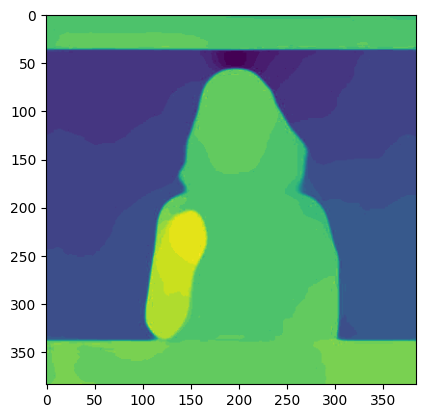

In [10]:
plt.imshow(img)

In [8]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

Using cache found in /home/myuser1/.cache/torch/hub/intel-isl_MiDaS_master


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0

In [9]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/myuser1/.cache/torch/hub/intel-isl_MiDaS_master


In [51]:
img.shape[:2]

(256, 256)

In [62]:
def get_depth(img):
    with torch.no_grad():
        prediction = midas(img)
   
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),            
            size=tuple(img.shape[2:]),
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    return prediction

In [73]:
def write_depth(depth, frame_number, out_path):
    # Format is depth_00001.jpg
    cv2.imwrite(os.path.join(out_path, f'depth_{frame_number:05d}.jpg'), depth.cpu().numpy())

In [72]:
def process_video(video_dir):
    for i, frame in enumerate(os.listdir(video_dir)):
        img = cv2.imread(os.path.join(video_dir,frame))
        img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img_transform = transform(img).to(device)
        depth = get_depth(img_transform)
        write_depth(depth, i+1, video_dir)

In [65]:
subset_dir = 'data/wlasl/rawframes/test_depth/'

In [74]:
def process_subset(subset_dir):
    for video in os.listdir(subset_dir):
        video_dir = os.path.join(subset_dir, video)
        process_video(video_dir)
        print(video_dir)

In [75]:
process_subset(subset_dir)

data/wlasl/rawframes/test_depth/01388
data/wlasl/rawframes/test_depth/00634


In [ ]:
video_dir

In [ ]:
img = process_frames(video_dir)

In [ ]:
img.shape

In [ ]:
transformed = transform(img).to(device)

In [ ]:
transformed.shape

In [1]:
def transform_batch(images):
    input_batch = transform(images[0])
    for i in range(1, len(images)):
        input_batch = torch.concat((input_batch, transform(images[i])), dim=0)
    return input_batch.to(device)

In [ ]:
input_batch = transform_batch(images)

In [ ]:
input_batch.shape

In [ ]:
def get_depth(input_batch):
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=(256,256),
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    return prediction

In [ ]:
depth = get_depth(input_batch)

In [ ]:
depth.shape

In [ ]:
plt.imshow(images[0])

In [ ]:
plt.imshow(depth[0].cpu())

In [ ]:
for image in depth:
    plt.imshow(image.cpu())
    break

In [ ]:
img = depth[0]

In [ ]:
img.min()

In [ ]:
cv2.imwrite('output.jpg', img.cpu().numpy())

In [ ]:
print(f'{12:05d}')

In [ ]:
def write_depth(depth, out_path):
    # Format is depth_00001.jpg
    for i, image in enumerate(depth):
        cv2.imwrite(video_dir + f'/depth_{i:05d}.jpg', image.cpu().numpy())

In [ ]:
write_depth(depth, video_dir)